<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 1. Maximum Marginal Relevance </b></div>

Maximal Marginal Relevance (MMR) is a method used to avoid redundancy while retrieving relevant items to a query. Instead of merely retrieving the most relevant items (which can often be very similar to each other), MMR ensures a balance between relevancy and diversity in the items retrieved. MMR always takes the documents that are most similar to the query in the embedding space, you may miss out on diverse information, as we saw in one of the edge cases in the last part of the previous notebook.

The idea behind MMR is that we send a query in, and then we initially get back a set of responses, with “**fetch_k**” being a parameter that we can control to determine how many responses we get. This is based solely on semantic similarity. We then work with that smaller set of documents and optimize for not only the most relevant ones, based on semantic similarity but also diverse ones. From that set of documents, we choose a final “k” to return to the user. 

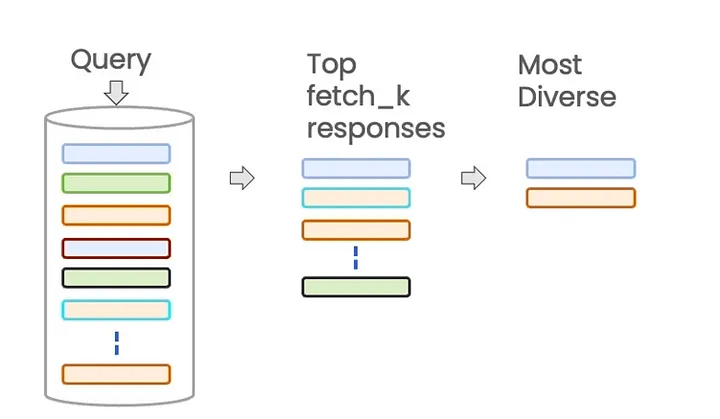


Let’s start by loading the environment variables and API keys and then import Chroma and OpenAI and the Chroma databases persist_directory that we created in the previous notebook.

In [1]:
!pip install LangChain -q
!pip install -U langchain-community -q
!pip install pypdf -q
!pip install yt_dlp -q
!pip install pydub -q
!pip install unstructured -q
!pip install docx2txt -q
!pip install openai -q
!pip install python-dotenv -q
!pip install xlrd -q
!pip install tiktoken -q
!pip install chromadb -q
!pip install lark -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.9.0 requires keras-core, which is not installed.
keras-nlp 0.12.1 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.1 which is incompatible.
jupyterlab 4.2.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpys

In [2]:
from openai import OpenAI
import openai
import os
import numpy as np
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
openai.api_key = user_secrets.get_secret("openai_api")
client = OpenAI(
    # This is the default and can be omitted
    api_key=openai.api_key,
)

llm_model = "gpt-3.5-turbo"

We will use OpenAI to create the text embeddings. Before jumping into a real-world example:

In [3]:
from langchain.embeddings.openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings(openai_api_key=openai.api_key)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


Let’s try it out with a few toy test cases just to get a sense of what’s going on underneath the hood. We will use the same example sentences we used before where the first two are very similar and the third one is unrelated:

In [4]:
sentence1 = "My dog Rover likes to chase squirrels"
sentence2 = "Fluffy my cat, refuses to eat from a can"
sentence3 = "The chevy bolt accelerates to 60 mph in 6.7 seconds"

We can then use the embedding class to create an embedding for each sentence. 



In [5]:
embedding1 = embedding.embed_query(sentence1)
embedding2 = embedding.embed_query(sentence2)
embedding3 = embedding.embed_query(sentence3)

We can then use NumPy to compare them and see which ones are most similar. We expect that the first two sentences should be very similar, and then the first and second compared to the third shouldn’t be nearly as similar. We’ll use a dot product to compare the two embeddings.

In [6]:
print('The similarity between sentences one and two is' , np.dot(embedding1, embedding2))
print('The similarity between sentences one and three is' , np.dot(embedding1, embedding3))
print('The similarity between sentences two and three' , np.dot(embedding2, embedding3))

The similarity between sentences one and two is 0.7994217224486891
The similarity between sentences one and three is 0.7492779153935134
The similarity between sentences two and three 0.6991800057325509


Here we can see that the first two embeddings have a pretty high score of 0.8. If we compare the first embedding to the third one, we can see that it’s lower at 0.75. And if we compare the second to the third the result is 0.69, which is also lower than the first two. 

Let’s now work with a real-world example. We are going to be working with the CS229 lectures as our main set of documents. First, we will load a few of them here. Notice that we’re going to duplicate the first lecture. This is to simulate some dirty data.



In [7]:
from langchain.document_loaders import PyPDFLoader

# Load PDF
loaders = [
    # Duplicate documents on purpose - messy data
    PyPDFLoader("/kaggle/input/machine-learning-lectures/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("/kaggle/input/machine-learning-lectures/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("/kaggle/input/machine-learning-lectures/MachineLearning-Lecture02.pdf"),
    PyPDFLoader("/kaggle/input/machine-learning-lectures/MachineLearning-Lecture03.pdf")
]
docs = []
for loader in loaders:
    docs.extend(loader.load())

After the documents are loaded, we can then use the recursive character text splitter to create chunks. We can see that we’ve now created over 200 different chunks:

In [8]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)

splits = text_splitter.split_documents(docs)
len(splits)

209

Now it is time to create embeddings for all the chunks of the PDFs and then store them in a vector store. The vector store that we’ll use for this lesson is the Chroma vector database.

LangChain has integrations with over 30 different vector stores. We will use the Chroma database because it’s lightweight and in memory, which makes it very easy to get up and start with. 

Other vector stores offer hosted solutions, which can be useful when you’re trying to persist large amounts of data or persist it in cloud storage somewhere. We will save this vector store so that we can use it in future notebook. 

Let’s create a variable called persist directory, which we will use later on, and also we will make sure that nothing is there already. If there’s data there already, it can throw things off and we don’t want that to happen.

In [9]:
from langchain.vectorstores import Chroma
persist_directory = 'docs/chroma/'
!rm -rf ./docs/chroma  # remove old database files if any

Let’s now create the vector store. We call Chroma from documents, passing in splits, and these are the splits that we created earlier, passing in embedding. This is the open AI embedding model and then passing in the persist directory, which is a Chroma-specific keyword argument that allows us to save the directory to disk.



In [10]:
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory
)

print(vectordb._collection.count())

209


Let’s now go over the example of max marginal relevance. We will load the text from the example where we have mushroom information. For this example, we’ll create a small database that we can just use as a toy example. We’ve got our question, and now we can run a similarity search.

In [11]:
texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]
smalldb = Chroma.from_texts(texts, embedding=embedding)
question = "Tell me about all-white mushrooms with large fruiting bodies"


We’ll set “k=2” to only return the two most relevant documents. And we can see that there is no mention of the fact that it is poisonous.

In [12]:
smalldb.similarity_search(question, k=2)

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(page_content='The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).')]

Let’s now run it with MMR. While it’s passing “k=2”, we still want to return two documents, but let’s set “fetch_k=3”, where we fetch all three documents.

In [13]:
smalldb.max_marginal_relevance_search(question,k=2, fetch_k=3)

[Document(page_content='A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.'),
 Document(page_content='A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.')]

We can now see that the poisonous information is returned among the documents that we retrieved.

Let’s take another example where we will ask about MATLAB and get back documents that had repeated information. We can take a look at the first two documents, just looking at the first few characters because they’re pretty long otherwise, and we can see that they’re the same.



In [14]:
question = "what did they say about matlab?"
docs_ss = vectordb.similarity_search(question,k=3)
docs_ss[0].page_content[:100]


'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

In [15]:
docs_ss[1].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

When we run MMR on these results, we can see that the first one is the same as before because that’s the most similar. But when we go on to the second one, we can see that it’s different. It’s getting some diversity in the responses.

In [16]:
docs_mmr = vectordb.max_marginal_relevance_search(question,k=3)
docs_mmr[0].page_content[:100]

'those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people '

In [17]:
docs_mmr[1].page_content[:100]

'algorithm then? So what’s different? How come  I was making all that noise earlier about \nleast squa'

<a id="2"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 2.Failure Cases  </b></div>



There are other situations when the query to the database is more than an asked question. Another type of retrieval is the self-query. This is useful when you get questions that aren’t solely about the content that you want to look up semantically but also include some mention of some metadata that you want to filter on.

Let's take this question, what are some movies about aliens made in 1980? This question has two components to it. It’s got a semantic part, the alien's part. Therefore we want to look up aliens in our database of movies. But it’s also got a piece that refers to the metadata about each movie, which is the fact that the year should be 1980.

What we can do is we can use a language model itself to split that original question into two separate things, a filter and a search term. Most vector stores support a metadata filter. So you can easily filter records based on metadata like the year equal to 1980.

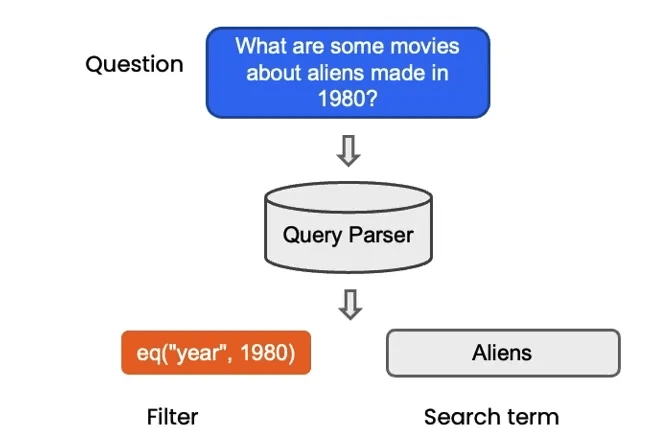

Let’s now move on to the self-query example. In the previous notebook, we asked this question what did they say about regression in the third lecture? and the semantic search results were from not just the third lecture, but also the first and the second. If we were fixing this by hand, what we would do is we’d specify a metadata filter. We will pass on this information that we want the source to be equal to the third lecture PDF. And then if we look at the documents that would be retrieved, they’d all be from exactly that lecture.

In [18]:
question = "what did they say about regression in the third lecture?"
docs = vectordb.similarity_search(
    question,
    k=3,
    filter={"source":"docs/cs229_lectures/MachineLearning-Lecture03.pdf"}
)

for d in docs:
    print(d.metadata)
    

We can use a language model to do this for us, so we don’t have to manually specify that. To do this, we’ll import a language model from OpenAI. We’ll import a retriever called the self-query retriever, and then we’ll import attribute info, which is where we can specify different fields in the metadata and what they correspond to.



In [19]:
from langchain.llms import OpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo


We only have two fields in the metadata, source and page. We fill out a description of the name, the description, and the type for each of these attributes. This information is actually going to be passed to the language model, so it’s important to make it as descriptive as possible.



In [20]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The lecture the chunk is from, should be one of `docs/cs229_lectures/MachineLearning-Lecture01.pdf`, `docs/cs229_lectures/MachineLearning-Lecture02.pdf`, or `docs/cs229_lectures/MachineLearning-Lecture03.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer",
    ),
]

We will then specify information about what’s actually in this document store. We will initialize the language model, and then we will initialize the self-query retriever using the “from_llm” method and passing in the language model, the underlying vector database that we’re going to query, the information about the description and the metadata, and then we’ll also pass in verbose=True. 

Setting verbose=True will let us see what’s going on underneath the hood when the LLM infers the query that should be passed along with any metadata filters. When we run the self-query retriever with this question, we can see, thanks to “verbose=True”, that we’re printing out what’s going on under the hood.


In [21]:
document_content_description = "Lecture notes"
llm = OpenAI(model='gpt-3.5-turbo-instruct', temperature=0, openai_api_key= openai.api_key )
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

question = "what did they say about regression in the third lecture?"

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


We got a query of regression, which is the semantic part, and then we got a filter where we have a comparator of equals between the source attribute and a value of docs and then this path, which is the path to the third machine learning lecture.

So this is telling us to do a lookup in the semantic space on regression and then do a filter where we only look at documents that have a source value of this value. And so if we loop over the documents and print out the metadata, we should see that they’re all from this third lecture.



In [22]:
for d in docs:
    print(d.metadata)


<a id="3"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 3.Retrieval by Comparison  </b></div>



The last retrieval technique is compression. This can be useful to pull out only the most relevant bits of the retrieved passages. When you ask a question, you will get back the whole document that was stored, even if only the first one or two sentences are the relevant parts. 

With compression, you can then run all those documents through a language model and then extract the most relevant segments. Then we pass only the most relevant segments into a final language model call. 

This comes at the cost of making more calls to the language model, but it’s also really good for focusing the final answer on only the most important things. So it’s a bit of a tradeoff.

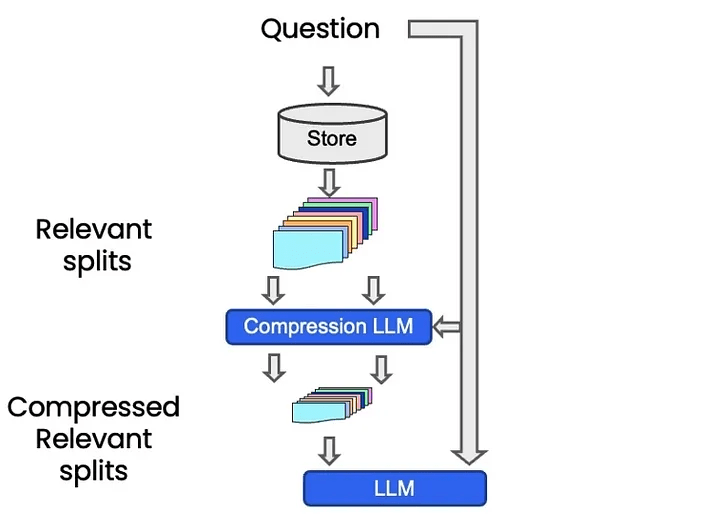


Let's put it into action to have a better understanding of how it works. Let’s load in some relevant modules here, the contextual compression retriever and then an LLM chain extractor. We will use these to extract only the relevant bits from each document and then pass those as the final return response.




In [23]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor


We’ll define a nice little function to pretty print out docs because they’re often long and confusing and this will make it easier to see what’s going on.



In [24]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))


We can then create a compressor with the LLM chain extractor and then we can create the contextual compression retriever passing in the compressor and then the base retriever of the vector store.



In [25]:
# Wrap our vectorstore
compressor = LLMChainExtractor.from_llm(llm)

compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)


We can now pass in the question, what did they say about MATLAB and we look at the compressed docs, if we look at the documents we get back, we can see two things:

* They are a lot shorter than the normal documents. 
* We still have repeated sentences going on and this is because under the hood we’re using the semantic search algorithm. We solved this by using MMR from earlier in this lesson.

In [26]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)


/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Document 1:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to plot data."
- "there's also a software package called Octave that you can download for free off the Internet."
- "it has somewhat fewer features than MATLAB, but it's free, and for the purposes of this class, it will work for just about everything."
- "once a colleague of mine at a different university, not at Stanford, actually teaches another machine learning course."
----------------------------------------------------------------------------------------------------
Document 2:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write 

<a id="4"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 4.Combining Various Retrieval Techniques  </b></div>


Let's finish this notebook with an example of where you can combine various techniques to get the best possible results. To do that, when we’re creating the retriever from the vector database, we can set the search type to MMR.



In [27]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr")
)


We can then rerun this and see that we get back a filtered set of results that do not contain any duplicate information. So far, all the additional retrieval techniques that we’ve mentioned are built on top of a vector database.



In [28]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)


Document 1:

- "those homeworks will be done in either MATLA B or in Octave"
- "I know some people call it a free ve rsion of MATLAB"
- "MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to plot data."
- "there's also a software package called Octave that you can download for free off the Internet."
- "it has somewhat fewer features than MATLAB, but it's free, and for the purposes of this class, it will work for just about everything."
- "once a colleague of mine at a different university, not at Stanford, actually teaches another machine learning course."
----------------------------------------------------------------------------------------------------
Document 2:

"Oh, it was the MATLAB."
----------------------------------------------------------------------------------------------------
Document 3:

- learning algorithms to teach a car how to drive at reasonably high 